Modèle chargé avec les poids 'model.h5'.
Dataset de test chargé avec 25 images.


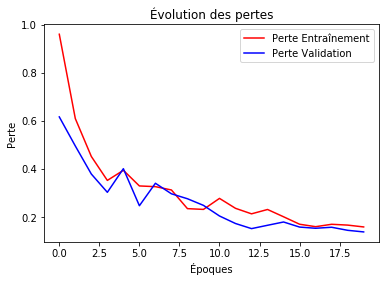

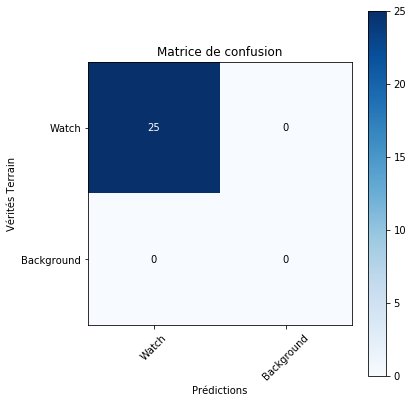

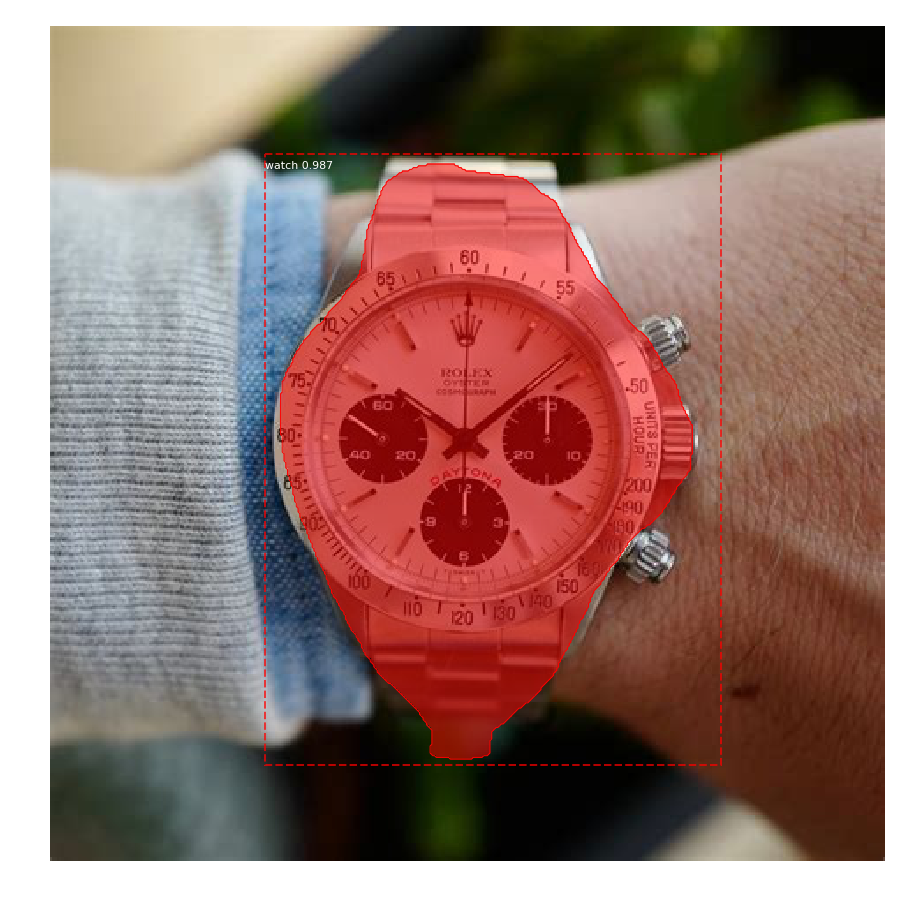

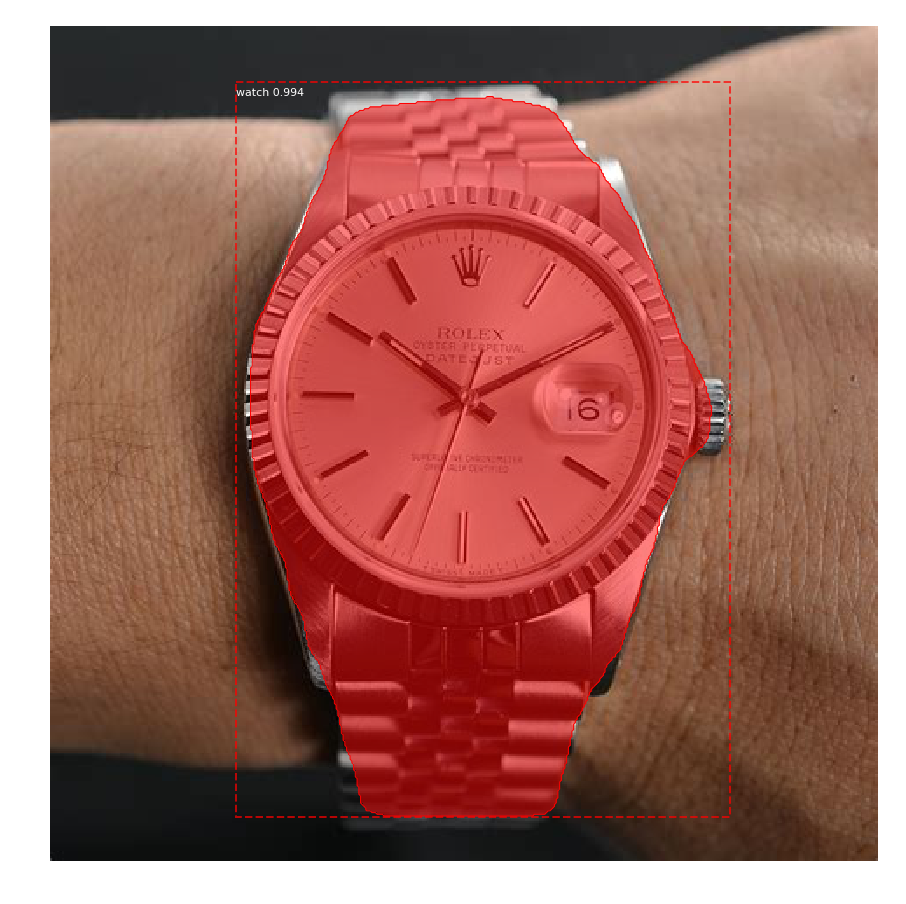

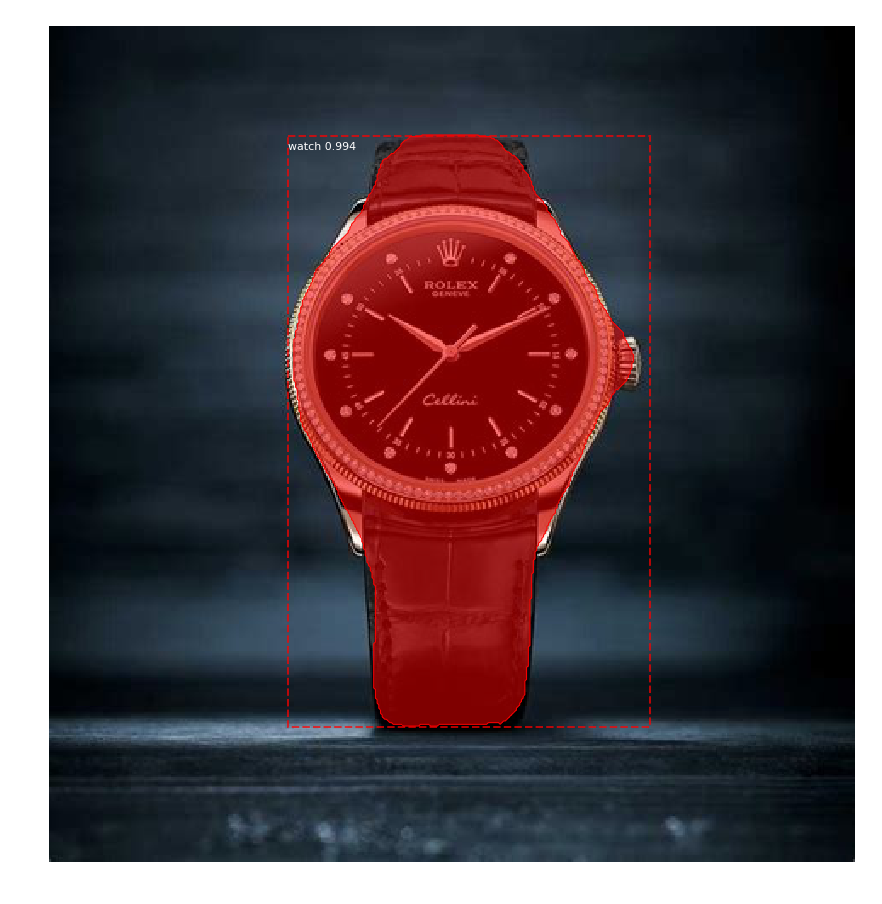

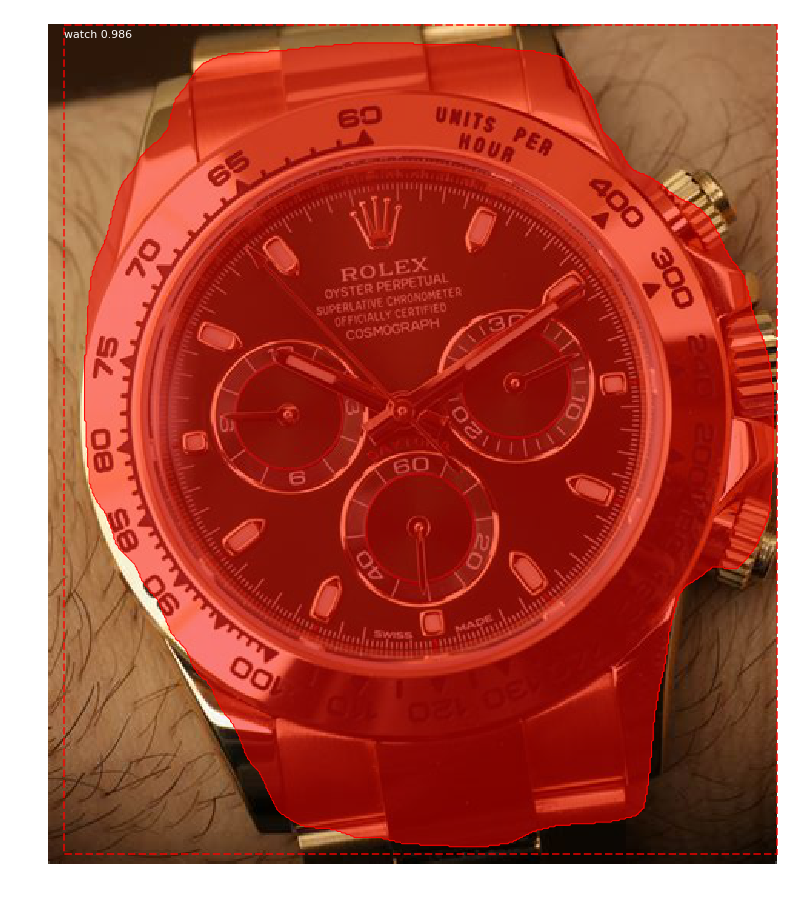

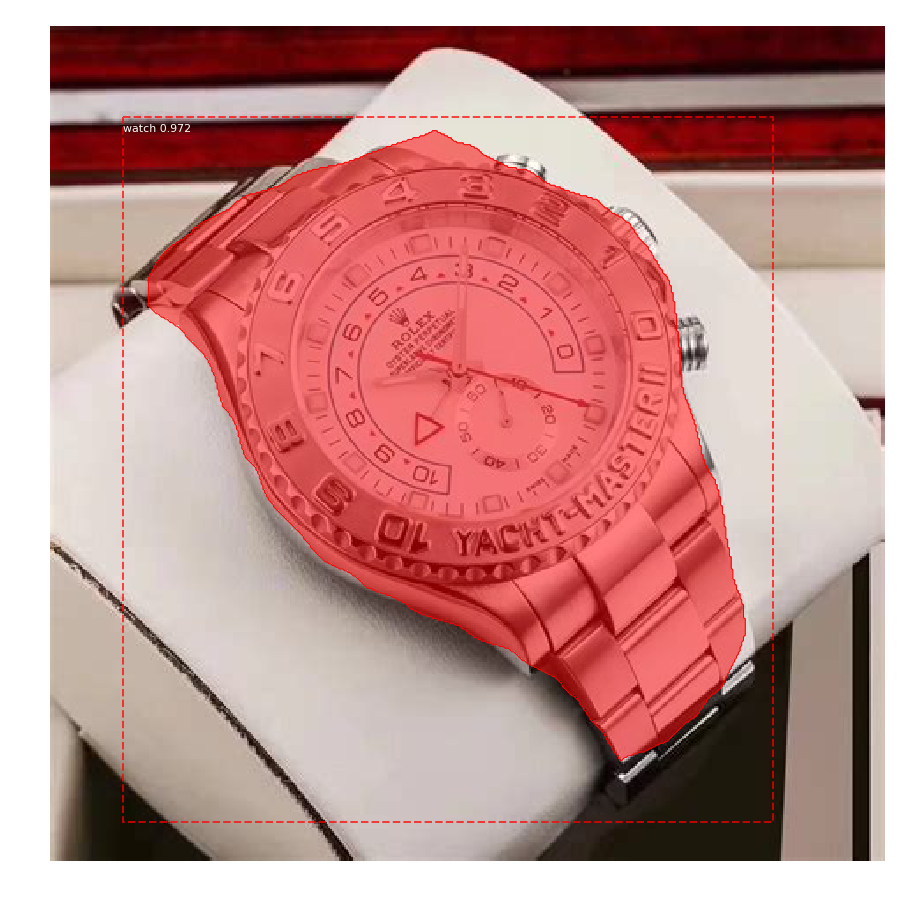

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import json
from skimage.io import imread
from mrcnn.model import MaskRCNN
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn.utils import Dataset
from skimage.draw import polygon as draw_polygon

# Configuration du modèle pour l'inférence
class InferenceConfig(Config):
    NAME = "Watch_detection"
    GPU_COUNT = 1  # 1 GPU (ou 1 CPU si aucun GPU n'est disponible)
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + Watch
    DETECTION_MIN_CONFIDENCE = 0.7
    IMAGE_MAX_DIM = 256

config = InferenceConfig()

# Charger le modèle pour l'inférence
model = MaskRCNN(mode="inference", config=config, model_dir="./logs")
model.load_weights("model.h5", by_name=True)
print("Modèle chargé avec les poids 'model.h5'.")

# Définir la classe du dataset pour les tests
class WatchDataset(Dataset):
    def load_watch(self, dataset_dir, subset):
        self.add_class("watch", 1, "watch")
        assert subset in ["train", "val", "test"], "Subset must be 'train', 'val', or 'test'"
        subset_dir = os.path.join(dataset_dir, subset)

        json_files = [f for f in os.listdir(subset_dir) if f.endswith('.json')]
        for json_file in json_files:
            with open(os.path.join(subset_dir, json_file)) as f:
                annotation = json.load(f)

            image_id = json_file.replace('.json', '')
            image_path = os.path.join(subset_dir, annotation['imagePath'])
            image = imread(image_path)
            height, width = image.shape[:2]

            polygons = []
            for shape in annotation.get('shapes', []):
                if shape['shape_type'] == 'polygon':
                    points = shape['points']
                    all_points_x = [point[0] for point in points]
                    all_points_y = [point[1] for point in points]
                    polygons.append({'all_points_x': all_points_x, 'all_points_y': all_points_y})

            self.add_image("watch", image_id=image_id, path=image_path, width=width, height=height, polygons=polygons)

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "watch":
            return super(WatchDataset, self).load_mask(image_id)

        height = image_info["height"]
        width = image_info["width"]
        polygons = image_info["polygons"]

        mask = np.zeros([height, width, len(polygons)], dtype=np.uint8)
        for i, p in enumerate(polygons):
            polygon = np.array(list(zip(p['all_points_x'], p['all_points_y'])))
            rr, cc = draw_polygon(polygon[:, 1], polygon[:, 0], shape=(height, width))
            mask[rr, cc, i] = 1

        return mask.astype(bool), np.ones([mask.shape[-1]], dtype=np.int32)

# Charger le dataset de test
test_dataset = WatchDataset()
test_dataset.load_watch(dataset_dir="dataset_watch", subset="val")
test_dataset.prepare()
print("Dataset de test chargé avec {} images.".format(len(test_dataset.image_ids)))

# Charger les événements TensorBoard pour obtenir les pertes
log_file = "./logs/watch_detection20241116T1515/events.out.tfevents.1731770135.239139636ae2"
event_acc = EventAccumulator(log_file)
event_acc.Reload()

# Extraire les pertes
train_losses = []
val_losses = []
epochs = []

if 'loss' in event_acc.Tags()['scalars'] and 'val_loss' in event_acc.Tags()['scalars']:
    train_loss_events = event_acc.Scalars('loss')
    val_loss_events = event_acc.Scalars('val_loss')

    for train_event, val_event in zip(train_loss_events, val_loss_events):
        epochs.append(train_event.step)
        train_losses.append(train_event.value)
        val_losses.append(val_event.value)
else:
    print("Les tags 'loss' et 'val_loss' n'ont pas été trouvés dans les logs.")
    exit()

# Afficher les courbes des pertes
plt.plot(epochs, train_losses, 'r', label="Perte Entraînement")
plt.plot(epochs, val_losses, 'b', label="Perte Validation")
plt.title("Évolution des pertes")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()
plt.savefig("train_validation_losses.png")
plt.show()

# Tester le modèle et collecter les résultats
true_labels = []
pred_labels = []

for image_id in test_dataset.image_ids:
    image = test_dataset.load_image(image_id)
    mask, class_ids = test_dataset.load_mask(image_id)

    # Prédictions du modèle
    results = model.detect([image], verbose=0)[0]

    # Vérités terrain
    true_labels.extend(class_ids)

    # Classes prédites
    if results['class_ids'].size > 0:
        pred_labels.extend(results['class_ids'])
    else:
        pred_labels.append(0)  # Si aucune détection, ajout de 0 pour "arrière-plan"

# Vérification que les tailles des listes sont égales avant de calculer la matrice de confusion
min_len = min(len(true_labels), len(pred_labels))
true_labels = true_labels[:min_len]
pred_labels = pred_labels[:min_len]

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=[1, 0])

# Visualisation de la matrice de confusion
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Watch", "Background"], rotation=45)
plt.yticks(tick_marks, ["Watch", "Background"])

# Annoter les cases de la matrice avec les valeurs de la matrice
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Vérités Terrain')  
plt.xlabel('Prédictions')  
plt.tight_layout()

# Sauvegarder la matrice de confusion dans un fichier PNG
plt.savefig("confusion_matrix.png")
plt.show()

# Visualisation de quelques résultats
for image_id in test_dataset.image_ids[:5]:
    image = test_dataset.load_image(image_id)
    results = model.detect([image], verbose=0)[0]
    visualize.display_instances(
        image, results['rois'], results['masks'], results['class_ids'],
        test_dataset.class_names, results['scores']
    )
    plt.show()
